# Perturbation for Lotka-Voltera model 

In [19]:
from scipy.integrate import solve_ivp
import numpy as np
from iterative_perturbation import general_perturbation_prediction
from iterative_perturbation import prediction_given_Sbool



In [20]:
def generate_model_params(num_native, A_mean, A_std_dev, u_mean, u_std_dev):
    a = np.random.rand(num_native, num_native)
    # Make the matrix symmetric, and has identity part
    A = A_mean + A_std_dev * (np.tril(a) + np.tril(a, -1).T) + np.eye(num_native) #need to expand this in the future for assymetric model
    u = np.random.normal(u_mean, u_std_dev, num_native)
    return A, u
    
def lotka_volterra(t, state, A, u, migration):
    return state * (u - A @ state)+ migration
    
def LV_simulator(initial_state, A, u, migration, max_time=500000, steady_state_threshold=1e-12):
    ode_function = lambda t, state: lotka_volterra(t, state, A, u, migration)

    def check_steady_state(t, y): #Since the aim in this notebook is to find steady states, we make a event 
        derivatives = ode_function(t, y)
        return np.max(np.abs(derivatives)) > steady_state_threshold

    # Integrate until steady state or max_time is reached
    check_steady_state.terminal = True
    sol = solve_ivp(ode_function, t_span=(0, max_time), y0=initial_state.copy(), method='LSODA', atol=1e-12, rtol=1e-12, events=[check_steady_state])
    
    # Check if the integration reached the maximum time
    time_limit_reached = sol.t[-1] == max_time
    if time_limit_reached: print('max integration time reached')
    
    return sol

def invasion(A, A_II,A_IS,A_SI, u, u_I):
    num_native = len(u)
    num_invaders = len(u_I)
    A_new = np.zeros((num_native + num_invaders, num_native + num_invaders))
    A_new[:num_native, :num_native] = A
    A_new[num_native:, :num_native] = A_IS
    A_new[:num_native, num_native:] = A_SI
    A_new[num_native:, num_native:] = A_II
    u_new = np.concatenate((u, u_I))
    return A_new, u_new

def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array

def mutation(mean_value, parent_zero_mean, random_zero_mean, mutation_correlation):
    # Apply mutation, which preserve mean and variance of parent
    return mean_value + mutation_correlation * parent_zero_mean+ np.sqrt(1-mutation_correlation**2) * (random_zero_mean)


def sample_invaders(num_invaders, num_native, A_mean, A_std_dev, u_mean, u_std_dev, parent_correlation, A_SS, u_S):
    
    num_parents = A_SS.shape[1]

    # Choose parent indices for each invader
    parent_indices = np.random.choice(num_parents, num_invaders)
    
    # Sample A_SI and A_IS with mutation
    parent_A_SI = A_SS[:, parent_indices] - A_mean
    random_A_SI = np.random.normal(0, A_std_dev, (num_native, num_invaders))
    A_SI = mutation(A_mean, parent_A_SI, random_A_SI, parent_correlation)

    parent_A_IS = A_SS[parent_indices, :] - A_mean
    random_A_IS = np.random.normal(0, A_std_dev, (num_invaders, num_native))
    A_IS = mutation(A_mean, parent_A_IS, random_A_IS, parent_correlation)
    
    # Sample u_I with mutation
    parent_u_I = u_S[parent_indices] - u_mean
    random_u_I = np.random.normal(0, u_std_dev, num_invaders)
    u_I = mutation(u_mean, parent_u_I, random_u_I, parent_correlation)
    
    # Sample A_II 
    A_II = 1 + np.random.normal(A_mean, A_std_dev, (num_invaders, num_invaders))
    
    return A_SI, A_IS, A_II, u_I





In [21]:
# Parameters
num_systems = 640
num_invaders = 1  # Number of invaders
num_knock_offs = 0 # Number of knock-offs
num_pool = 10
parent_correlation=0 #correlation coefficcient with parent
A_mean = 2
A_std_dev = 0.2
u_mean = 2
u_std_dev = 0.1
deltau_mean = 0
deltau_std_dev = 0
migration=0
Xthreshold=1e-5

ODE_steady_states = []
old_ODE_steady_states = []
perturbation_predictions = []
info_predicted_Xs = []
sim_Xbools=[]
predicted_Xbools=[]
list_invasion_fitness=[]
list_screened_invader_impact=[]
list_M_inv=[]

for system_idx in range(num_systems):
    # Generate model parameters for each system
    A, u = generate_model_params(num_pool, A_mean, A_std_dev, u_mean, u_std_dev)
    initial_state = np.ones(num_pool)

    # Simulate the initial system
    sol = LV_simulator(initial_state, A, u,migration)
    oldX = sol.y.T[-1]
    
    # Take the initial surviving system 
    Sbool=[(x > Xthreshold) for x in oldX] 
    num_native=sum(Sbool)
    As, us, oldXs = A[Sbool,::][::,Sbool],u[Sbool],oldX[Sbool]
    old_ODE_steady_states.append(oldXs)
    
    # Sample invaders
    keep_sampling=True
    
    while keep_sampling:
        A_SI, A_IS, A_II,u_I = sample_invaders(num_invaders, num_native, A_mean, A_std_dev, u_mean, u_std_dev, parent_correlation, As,us)
        
        if u_I-A_IS@oldXs>0: #conditional on positive invasion fitness
            keep_sampling=False

    # Set knock off species from the system
    knock_off=np.array([False]*len(As))
    knock_off=set_random_true(knock_off, num_knock_offs)
    #print(knock_off)
    
    #Sample environmental perturbation
    delta_u=np.random.normal(deltau_mean, deltau_std_dev, num_native)
    
    # Add invaders
    A_new, u_new = invasion(As, A_II,A_IS,A_SI, us+delta_u, u_I)
    new_initial_state = np.ones(num_native + num_invaders)

    # Simulate the new system with the invaders
    new_sol = LV_simulator(new_initial_state, A_new, u_new, migration)
    newX=new_sol.y.T[-1]
    simulator_Sbool=[(x > Xthreshold) for x in newX]
    
    #ODE_steady_state = new_sol.y.T[-1]
    ODE_steady_states.append(newX)
    
    # Compute perturbation prediction given what survives
    num_original=len(As)
    #info_predicted_X=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,simulator_Sbool[:num_original],simulator_Sbool[num_original:])
    info_predicted_X, screened_invader_impact, M_inv, invasion_fitness=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,simulator_Sbool[:num_original],simulator_Sbool[num_original:])
    info_predicted_Xs.append(info_predicted_X)

    list_invasion_fitness.append(invasion_fitness[0])
    list_screened_invader_impact.append(screened_invader_impact)
    list_M_inv.append(M_inv[0,0])
    
    
    # Compute perturbation prediction from iterative appoarch
    predicted_XList=general_perturbation_prediction(As,oldXs,us,delta_u,knock_off,A_II,A_IS,A_SI, u_I, num_iters=50, momentum=0.1,survival_threshold=Xthreshold)
    perturbation_prediction = np.array(predicted_XList)[-1]
    prediction_Sbool=[(x > Xthreshold) for x in perturbation_prediction]
    perturbation_predictions.append(perturbation_prediction)

    # Save prediction and simulation Bools
    sim_Xbools.append(simulator_Sbool)
    predicted_Xbools.append(prediction_Sbool)
   

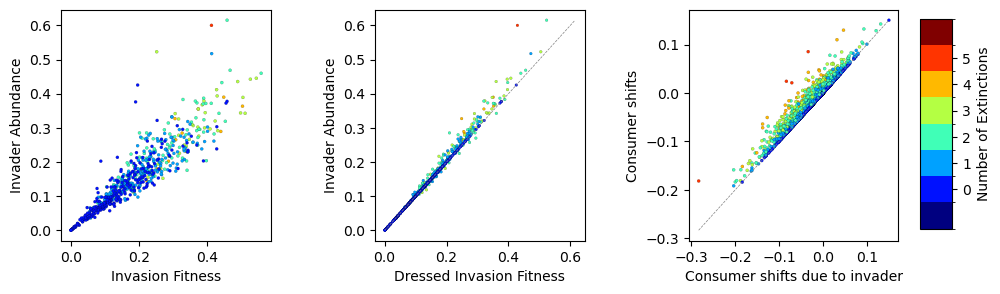

In [22]:
from matplotlib.colors import BoundaryNorm
import numpy as np
import matplotlib.pyplot as plt

# Calculate the number of extinctions
num_ext_list = []
for sim_Xbool in sim_Xbools:
    Nextbool = np.logical_not(sim_Xbool)
    num_ext_list.append(sum(Nextbool))

figure_width = 3
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3.6, figure_width))  # Create 3 subplots

# Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

invader_abundance = np.array([arr[-1] for arr in ODE_steady_states])
weighted_invader_impact=[]
for scalar, vector in zip(invader_abundance, list_screened_invader_impact):
        weighted_invader_impact.append(scalar * vector)

# Calculate N_shifts
X_shifts = []

for i in range(len(old_ODE_steady_states)):
    X_sur_before = old_ODE_steady_states[i][sim_Xbools[i][:-1]]
    X_sur_after = ODE_steady_states[i][sim_Xbools[i]][:-1]
    X_shifts.append(X_sur_after - X_sur_before)



### First plot (now on ax[1], reversed)
x1 = np.multiply(list_invasion_fitness, list_M_inv)
y1 = invader_abundance

# Create a structured array for sorting
data1 = np.array(list(zip(num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
sorted_data1 = np.sort(data1, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_1 = sorted_data1['extinctions']
sorted_x1 = sorted_data1['x']
sorted_y1 = sorted_data1['y']

# Scatter plot for ax[1]
scatter1 = ax[1].scatter(sorted_x1, sorted_y1,
                         s=4,
                         c=sorted_num_ext_list_1,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

# Add dashed line where x=y
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[1].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

ax[1].set_ylabel('Invader Abundance')
ax[1].set_xlabel('Dressed Invasion Fitness')

### Second plot (now on ax[0], reversed)
x2 = list_invasion_fitness
y2 = invader_abundance

# Create a structured array for sorting
data2 = np.array(list(zip(num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
sorted_data2 = np.sort(data2, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_2 = sorted_data2['extinctions']
sorted_x2 = sorted_data2['x']
sorted_y2 = sorted_data2['y']

# Scatter plot for ax[0]
scatter2 = ax[0].scatter(sorted_x2, sorted_y2,
                         s=5,
                         alpha=1,
                         c=sorted_num_ext_list_2,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[0].set_ylabel('Invader Abundance')
ax[0].set_xlabel('Invasion Fitness')

### Third plot (new one on ax[2])
# Extend the color to the same length of shifts
Xextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Xextended_num_ext_list += [num_ext_list[i]] * len(X_shifts[i])

# Data for the third plot (on ax[2])
x3 = -np.concatenate(weighted_invader_impact)
y3 = np.concatenate(X_shifts)

# Scatter plot for ax[2]
scatter3 = ax[2].scatter(x3, y3,
                         s=5,
                         c=Xextended_num_ext_list,
                         cmap='jet',
                         alpha=1,
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[2].set_ylabel('Consumer shifts')
ax[2].set_xlabel('Consumer shifts due to invader')

# Add dashed line where x=y for the third plot (on ax[2])
max_limit_3 = max(x3.max(), y3.max())
min_limit_3 = min(x3.min(), y3.min())
ax[2].plot([min_limit_3, max_limit_3], [min_limit_3, max_limit_3], color='gray', linestyle='dashed', linewidth=0.5)

### Colorbar (shared between all plots)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust position to fit all subplots
cbar = fig.colorbar(scatter3, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(Xextended_num_ext_list), np.max(Xextended_num_ext_list) + 1))
cbar.set_label('Number of Extinctions')

plt.subplots_adjust(wspace=0.5)
plt.savefig('combined_colorful_plot.pdf', bbox_inches='tight')
plt.show()


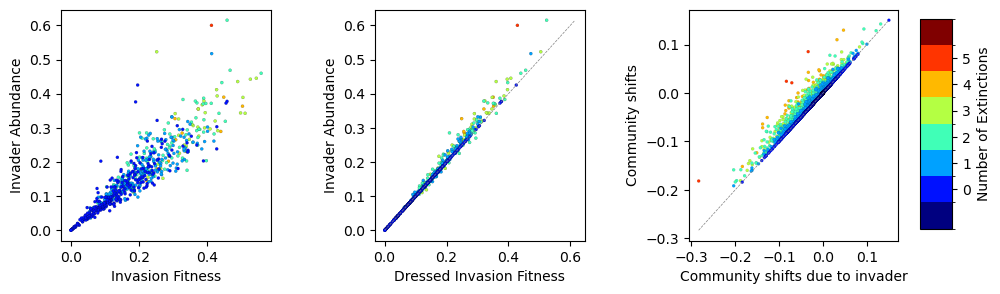

In [23]:
from matplotlib.colors import BoundaryNorm
import numpy as np
import matplotlib.pyplot as plt

# Calculate the number of extinctions
num_ext_list = []
for sim_Xbool in sim_Xbools:
    Nextbool = np.logical_not(sim_Xbool)
    num_ext_list.append(sum(Nextbool))

figure_width = 3
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3.6, figure_width))  # Create 3 subplots

# Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

invader_abundance = np.array([arr[-1] for arr in ODE_steady_states])

### First plot (now on ax[1], reversed)
x1 = np.multiply(list_invasion_fitness, list_M_inv)
y1 = invader_abundance

# Create a structured array for sorting
data1 = np.array(list(zip(num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
sorted_data1 = np.sort(data1, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_1 = sorted_data1['extinctions']
sorted_x1 = sorted_data1['x']
sorted_y1 = sorted_data1['y']

# Scatter plot for ax[1]
scatter1 = ax[1].scatter(sorted_x1, sorted_y1,
                         s=5,
                         c=sorted_num_ext_list_1,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

# Add dashed line where x=y
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[1].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

ax[1].set_ylabel('Invader Abundance')
ax[1].set_xlabel('Dressed Invasion Fitness')

### Second plot (now on ax[0], reversed)
x2 = list_invasion_fitness
y2 = invader_abundance

# Create a structured array for sorting
data2 = np.array(list(zip(num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
sorted_data2 = np.sort(data2, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_2 = sorted_data2['extinctions']
sorted_x2 = sorted_data2['x']
sorted_y2 = sorted_data2['y']

# Scatter plot for ax[0]
scatter2 = ax[0].scatter(sorted_x2, sorted_y2,
                         s=5,
                         alpha=1,
                         c=sorted_num_ext_list_2,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[0].set_ylabel('Invader Abundance')
ax[0].set_xlabel('Invasion Fitness')

### Third plot (new one on ax[2], now sorted by Xextended_num_ext_list)
# Extend the color to the same length of shifts
Xextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Xextended_num_ext_list += [num_ext_list[i]] * len(X_shifts[i])

# Data for the third plot (on ax[2])
x3 = -np.concatenate(weighted_invader_impact)
y3 = np.concatenate(X_shifts)

# Create a structured array for sorting based on Xextended_num_ext_list
data3 = np.array(list(zip(Xextended_num_ext_list, x3, y3)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
sorted_data3 = np.sort(data3, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_3 = sorted_data3['extinctions']
sorted_x3 = sorted_data3['x']
sorted_y3 = sorted_data3['y']

# Scatter plot for ax[2]
scatter3 = ax[2].scatter(sorted_x3, sorted_y3,
                         s=5,
                         c=sorted_num_ext_list_3,
                         cmap='jet',
                         alpha=1,
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.05)

ax[2].set_ylabel('Community shifts')
ax[2].set_xlabel('Community shifts due to invader')

# Add dashed line where x=y for the third plot (on ax[2])
max_limit_3 = max(sorted_x3.max(), sorted_y3.max())
min_limit_3 = min(sorted_x3.min(), y3.min())
ax[2].plot([min_limit_3, max_limit_3], [min_limit_3, max_limit_3], color='gray', linestyle='dashed', linewidth=0.5)

### Colorbar (shared between all plots)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust position to fit all subplots
cbar = fig.colorbar(scatter3, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(Xextended_num_ext_list), np.max(Xextended_num_ext_list) + 1))
cbar.set_label('Number of Extinctions')

plt.subplots_adjust(wspace=0.5)
plt.savefig('combined_colorful_plot.pdf', bbox_inches='tight')
plt.show()


In [24]:
 from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()

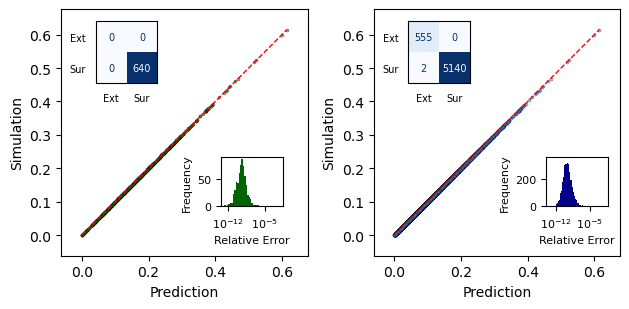

In [25]:
# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2, figure_width * 1))

# Filter data for positive predictions
sim_Xbools_concatenated = np.concatenate(sim_Xbools)
prediction_Xbool_concatenated = np.concatenate(predicted_Xbools)
intersection = [a and b for a, b in zip(sim_Xbools_concatenated, prediction_Xbool_concatenated)]
positive_indices = np.array(intersection) > 0

filtered_simulationX_after = np.concatenate(ODE_steady_states)[positive_indices]
filtered_predictionXs = np.concatenate(perturbation_predictions)[positive_indices]

# Filter N_0 data for positive predictions
simulation_invader = np.array([x[-1] for x in ODE_steady_states])
prediction_invader = np.array([x[-1] for x in perturbation_predictions])
threshold_invader = 1e-8 # Define a threshold value if needed
sim_invader_bool = simulation_invader > threshold_invader
pred_invader_bool = prediction_invader > threshold_invader
intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0

filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]

# Scatter plot for N_0 (reversed axes)
maxX0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.5, linewidth=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxX0], [0, maxX0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxX0 * 0.1, 1.1 * maxX0)
ax[0].set_ylim(-maxX0 * 0.1, 1.1 * maxX0)
#ax[0].set_title(f'invader')

# Add confusion matrix inset for N_0
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool.astype(int), pred_invader_bool.astype(int), ax=inset_ax_n0)

# Histogram for relative error of N_0
ax_hist2 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist2.set_xticks([-12, -5])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-12}$', '$10^{-5}$'])  # Replace with your desired tick labels


# Scatter plot for N (reversed axes)
maxX = np.max(np.concatenate(ODE_steady_states))
scatter_n = ax[1].scatter(filtered_predictionXs, filtered_simulationX_after, s=5, alpha=0.5, linewidth=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxX], [0, maxX], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxX * 0.1, 1.1 * maxX)
ax[1].set_ylim(-maxX * 0.1, 1.1 * maxX)
#ax[1].set_title(f'community')

# Add confusion matrix inset for N
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Xbools_concatenated, prediction_Xbool_concatenated, ax=inset_ax_n)

# Histogram for relative error of N
ax_hist0 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulationX_after - filtered_predictionXs) / filtered_simulationX_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-12, -5])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-12}$', '$10^{-5}$'])  # Replace with your desired tick labels


plt.tight_layout()
fig.savefig("single_LV_work.svg", format="svg")
fig.savefig("single_LV_work.pdf", format="pdf")

plt.show()


640 0


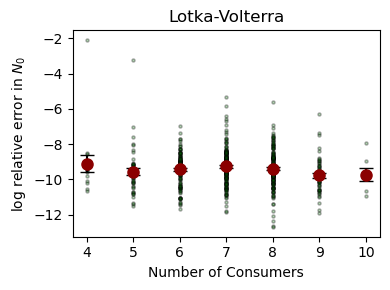

In [26]:
n_consumers=[]
similarity_score=[]
count_yes=0
count_no=0
for sim_bool, pred_bool in zip(sim_Xbools,predicted_Xbools):
    # Get intersection of where both sim and pred are True
    intersection = np.logical_and(sim_bool[:-1], pred_bool[:-1])
    
    if pred_bool[-1] and sim_bool[-1]:
        count_yes+=1
        n_consumers.append(np.sum(intersection))
        similarity_score.append(np.sum(intersection)/len(sim_bool))

    else:count_no+=1
print(count_yes,count_no)

# Create a new figure for relative error vs number of consumers
# plt.figure(figsize=(6, 4))

# Calculate relative error for N_0
relative_error_N0 = np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader


# # Create scatter plot
# plt.scatter(n_consumers, relative_error_N0, alpha=0.3, s=5, c='darkgreen', edgecolor='black')
# plt.yscale('log')

# plt.xlabel('Number of Consumers')
# plt.ylabel('Relative Error in $N_0$')
# plt.title('Relative Error vs Number of Consumers')


# plt.tight_layout()
# plt.savefig("Monod_error_vs_consumers.pdf", format="pdf")
# plt.show()
# Create arrays to store mean and percentiles for each unique number of consumers
unique_n_consumers = np.unique(n_consumers)
mean_errors = []
error_bars = []
# percentile_25 = []
# percentile_75 = []

# Calculate statistics for each unique number of consumers
for n in unique_n_consumers:
    mask = np.array(n_consumers) == n
    errors = relative_error_N0[mask]
    
    # Calculate statistics in log scale
    log_errors = np.log10(errors)
    mean_errors.append(np.mean(log_errors))
    error_bars.append(np.std(log_errors)/np.sqrt(len(errors)))

# Convert back to linear scale
# mean_errors = 10**np.array(mean_errors)
# error_bars = 10**np.array(error_bars)
#percentile_25 = 10**np.array(percentile_25)
#percentile_75 = 10**np.array(percentile_75)

# Create error bars (asymmetric in log scale)
#yerr_low = mean_errors - percentile_25
#yerr_high = percentile_75 - mean_errors

# Create new figure
plt.figure(figsize=(4, 3))

# Plot mean with error bars
plt.errorbar(unique_n_consumers, mean_errors, yerr=error_bars, 
             fmt='o', capsize=5, capthick=1, ecolor='black', 
             markersize=8, color='darkred', label='Mean with standard error')
plt.scatter(n_consumers, np.log10(relative_error_N0), alpha=0.3, s=5, c='darkgreen', edgecolor='black')

#plt.yscale('log')
plt.xlabel('Number of Consumers')
plt.ylabel('log relative error in $N_0$')
plt.title('Lotka-Volterra')
#plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig("LV_mean_error_vs_consumers.pdf", format="pdf")
plt.show()

# Create a separate figure just for the legend
legend_fig = plt.figure(figsize=(2, 1))
ax = legend_fig.add_subplot(111)

# Create dummy plots with the same style as the main figure
ax.scatter([], [], alpha=0.3, s=5, c='darkgreen', edgecolor='black', label='Individual simulations')
ax.errorbar([], [], yerr=[], fmt='o', capsize=5, capthick=1, ecolor='black',
            markersize=8, color='darkred', label='Mean with standard error')

# Get the legend
legend = ax.legend(frameon=False)

# Save just the legend
legend_fig.canvas.draw()
bbox = legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted())
legend_fig.savefig("mean_relative_error_legend.pdf", format="pdf", bbox_inches=bbox)
plt.close(legend_fig)





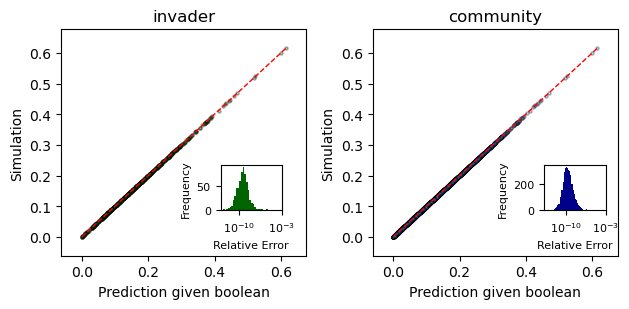

In [27]:
# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2, figure_width * 1))

# Filter data for positive predictions
sim_Xbools_concatenated = np.concatenate(sim_Xbools)
prediction_Xbool_concatenated = np.concatenate(predicted_Xbools)
intersection = [a and b for a, b in zip(sim_Xbools_concatenated, prediction_Xbool_concatenated)]
positive_indices = np.array(intersection) > 0

filtered_simulationX_after = np.concatenate(ODE_steady_states)[positive_indices]
filtered_predictionXs = np.concatenate(info_predicted_Xs)[positive_indices]

# Filter N_0 data for positive predictions
simulation_invader = np.array([x[-1] for x in ODE_steady_states])
prediction_invader = np.array([x[-1] for x in info_predicted_Xs])
threshold_invader = 1e-8 # Define a threshold value if needed
sim_invader_bool = simulation_invader > threshold_invader
pred_invader_bool = prediction_invader > threshold_invader
intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0

filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]

# Scatter plot for N_0 (reversed axes)
maxX0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxX0], [0, maxX0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction given boolean')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxX0 * 0.1, 1.1 * maxX0)
ax[0].set_ylim(-maxX0 * 0.1, 1.1 * maxX0)
ax[0].set_title(f'invader')

# Histogram for relative error of N_0
ax_hist2 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist2.set_xticks([-10, -3])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-10}$', '$10^{-3}$'])  # Replace with your desired tick labels


# Scatter plot for N (reversed axes)
maxX = np.max(np.concatenate(ODE_steady_states))
scatter_n = ax[1].scatter(filtered_predictionXs, filtered_simulationX_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxX], [0, maxX], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction given boolean')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxX * 0.1, 1.1 * maxX)
ax[1].set_ylim(-maxX * 0.1, 1.1 * maxX)
ax[1].set_title(f'community')

# Histogram for relative error of N
ax_hist0 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulationX_after - filtered_predictionXs) / filtered_simulationX_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-10, -3])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-10}$', '$10^{-3}$'])  # Replace with your desired tick labels


plt.tight_layout()

plt.show()


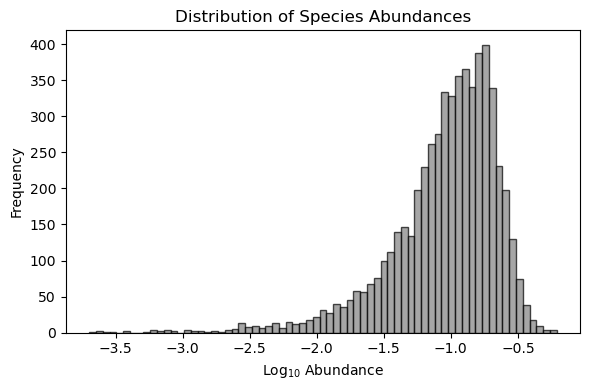

In [28]:
# Create histogram of log abundances
plt.figure(figsize=(6, 4))

# Combine all abundances (both simulation and prediction)
all_abundances = np.concatenate([filtered_simulationX_after, filtered_simulation_invader])

# Create histogram of log10 abundances
plt.hist(np.log10(all_abundances), bins='auto', color='gray', edgecolor='black', alpha=0.7)
plt.xlabel('Log$_{10}$ Abundance')
plt.ylabel('Frequency')
plt.title('Distribution of Species Abundances')

plt.tight_layout()
plt.show()
